<a href="https://colab.research.google.com/github/carlosbarrone/public_notebooks/blob/dev/disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data'

In [23]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Description of the project, data and objectives
This project main objective is to develop an algorithm that is able to identify the true disaster tweets from a set of tweets. The performance of the model will be evaluated on the F1 scores of the submission. The data is already divided into two separate datasets:

1. Train data
2. Test data

And has a separate file with the true labels of the train data as a CSV file.

Here is the size and dimensions of the data:

In [27]:
train_raw_df = pd.read_csv(f'{DATA_PATH}/disaster_tweets/train.csv')
test_raw_df = pd.read_csv(f'{DATA_PATH}/disaster_tweets/test.csv')
n_samples_train, _ = train_raw_df.shape
n_samples_test, _ = test_raw_df.shape
print(f'Number of training tweets: {n_samples_train}')
print(f'Number of test tweets: {n_samples_test}')
print(f'Total number of tweets: {n_samples_train+n_samples_test}')
print(f'Train tweets %: {n_samples_train/(n_samples_train+n_samples_test)}')
train_raw_df.sample(3)

Number of training tweets: 7613
Number of test tweets: 3263
Total number of tweets: 10876
Train tweets %: 0.6999816108863552


,id,keyword,location,text,target
796,1154,blight,"Johannesburg, South Africa",'If you are going to achieve excellence in big...,0
1764,2537,collision,"Peterborough, Ontario, Canada",Two-vehicle collision at Fowlers Corners at Hw...,1
363,521,army,Mexico! ^_^,5 Seconds of Summer Is my pick for http://t.co...,0


The dataset contains 10,876 total tweets, with 7,613 ($\approx$ 70%) tweets for training and 3,263 ($\approx$ 30%) you can see a sample above.

Here is the distribution of true and false labels:

<Figure size 800x600 with 0 Axes>

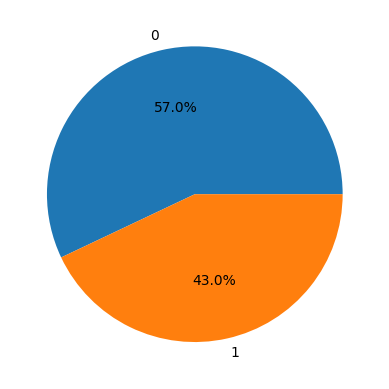

In [4]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
labels, counts = np.unique(train_raw_df.target, return_counts=True)
ax.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

It looks like it is slightly imbalanced.

# EDA

In [5]:
def delete_empty(x):
  return ' '.join([e for e in x if e != ''])

class Project_Data:
  def __init__(self, train_set_raw: pd.DataFrame, test_set_raw: pd.DataFrame, vocabulary_size: int, seed: int = 2020, min_rep_count:int = 10) -> None:
    self.X_train, self.y_train = self.tweak_data(train_set_raw, test_set_raw, seed)
    self.max_text_length = self.X_train.text.str.len().max()
    self.vocabulary_size = vocabulary_size
    self.X_test = test_set_raw.text
    self.test_ids = test_set_raw.id
    self.df_text_metrics = pd.DataFrame({
        'label': train_set_raw.target,
        'text_length': train_set_raw.text.str.len(),
        'num_words': train_set_raw.text.str.split(' ').apply(len)
    })

  def clean_text(self, df: pd.DataFrame):
    df.text = df.text.str.strip()
    df.text = df.text.str.lower()
    df.text = df.text.apply(lambda s: s.replace("'",""))
    df.text = df.text.apply(lambda s: re.sub(r'http\S+|www\S+', '', s))
    df.text = df.text.apply(lambda s: re.sub(r'[^\x00-\x7F]+', '', s))
    df.text = df.text.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]+', '', s))
    df.text = df.text.str.split(' ').apply(delete_empty)
    return df

  def tweak_data(self, train_set_raw: pd.DataFrame, test_set_raw: pd.DataFrame, seed: int):
    train_set_raw = self.clean_text(train_set_raw)
    test_set_raw = self.clean_text(test_set_raw)
    X_train, y_train = train_set_raw[['id', 'text']], train_set_raw[['id', 'target']]
    return X_train, y_train

  def get_data(self):
    return self.X_train.text, self.y_train.target

In [6]:
def build_encoder(df: pd.DataFrame, vocabulary_size: int):
  encoder = TextVectorization(max_tokens=vocabulary_size)
  encoder.adapt(df.to_list())
  return encoder

def build_validation_graph(history, model_name: str = ''):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'Model accuracy {model_name}')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

vocabulary_size = 2000
project_data = Project_Data(train_raw_df, test_raw_df, vocabulary_size=vocabulary_size)

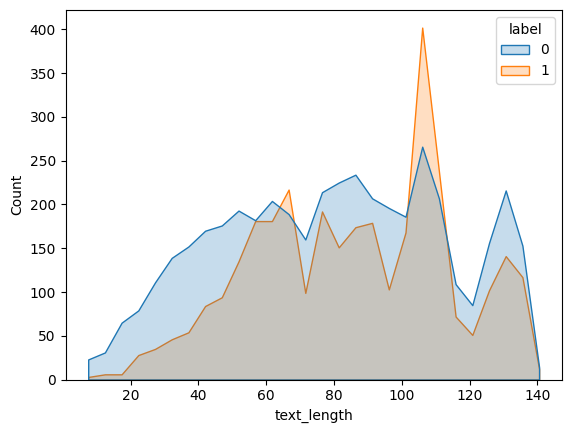

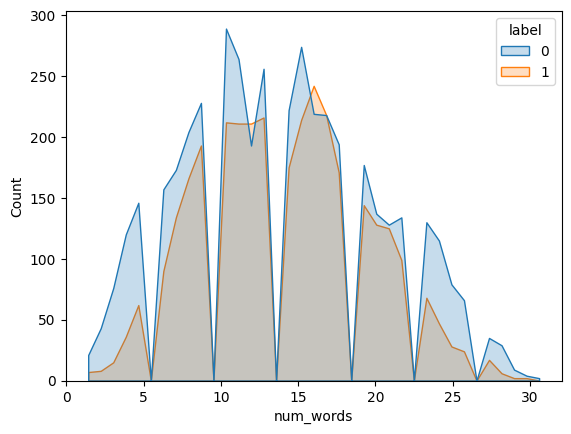

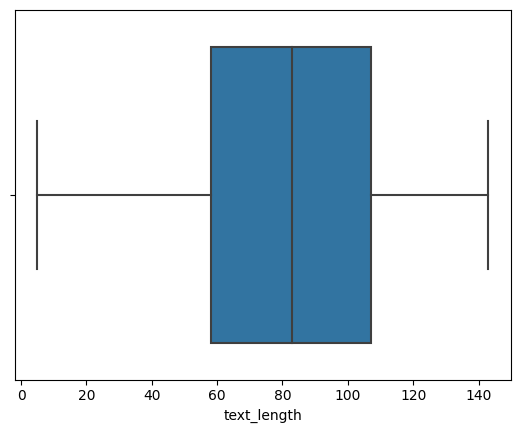

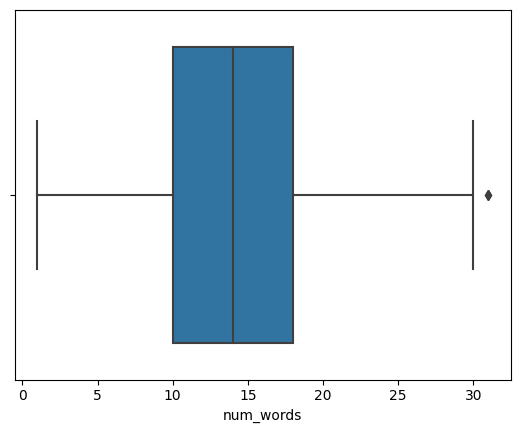

In [7]:
sns.histplot(data=project_data.df_text_metrics, x="text_length", hue="label", element="poly")
plt.show()
sns.histplot(data=project_data.df_text_metrics, x="num_words", hue="label", element="poly")
plt.show()
sns.boxplot(data=project_data.df_text_metrics, x="text_length")
plt.show()
sns.boxplot(data=project_data.df_text_metrics, x="num_words")
plt.show()

In the above charts we can see the distribution and outliers from the length of the tweets and the number of words of the tweets, I thought it was very interesting to see that the true labels mean was close above 60 characters, I expected it to be much shorter and concise!

# Data Pre-Processing

With the above class and functions I am deleting al URL's, special characters, and emojis. Also It's important to delete any whitespace at start/end and in between the text.

# Long Short Term Memory (LSTM) Model

In [8]:
drop_lstm = 0.3
optimizer = Adam(learning_rate=0.00004)
X_train, y_train = project_data.get_data()
X_test = project_data.X_test
test_ids = project_data.test_ids
encoder_lstm = build_encoder(X_train, project_data.vocabulary_size)

output_dims = project_data.max_text_length
model_lstm = Sequential()
model_lstm.add(encoder_lstm)
model_lstm.add(Embedding(input_dim=len(encoder_lstm.get_vocabulary()),output_dim=output_dims, mask_zero=True))
model_lstm.add(SpatialDropout1D(drop_lstm))
model_lstm.add(LSTM(output_dims, return_sequences=False))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 143)         286000    
                                                                 
 spatial_dropout1d (Spatial  (None, None, 143)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 143)               164164    
                                                                 
 dense (Dense)               (None, 1)                 144       
                                                                 
Total params: 450308 (1.72 MB)
Trainable params: 450308 

In [9]:
model_lstm.compile(loss = 'binary_crossentropy', optimizer = optimizer , metrics = ['accuracy'])

In [10]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000000001)
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks =[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
191/191 [==============================] - 37s 131ms/step - loss: 0.6859 - accuracy: 0.5762 - val_loss: 0.6859 - val_accuracy: 0.5345 - lr: 4.0000e-05
Epoch 2/30
191/191 [==============================] - 32s 170ms/step - loss: 0.6631 - accuracy: 0.5951 - val_loss: 0.6682 - val_accuracy: 0.5824 - lr: 4.0000e-05
Epoch 3/30
191/191 [==============================] - 20s 104ms/step - loss: 0.6091 - accuracy: 0.7209 - val_loss: 0.6021 - val_accuracy: 0.7288 - lr: 4.0000e-05
Epoch 4/30
191/191 [==============================] - 25s 133ms/step - loss: 0.5381 - accuracy: 0.7811 - val_loss: 0.5734 - val_accuracy: 0.7400 - lr: 4.0000e-05
Epoch 5/30
191/191 [==============================] - 16s 84ms/step - loss: 0.4913 - accuracy: 0.7995 - val_loss: 0.5418 - val_accuracy: 0.7479 - lr: 4.0000e-05
Epoch 6/30
191/191 [==============================] - 26s 134ms/step - loss: 0.4561 - accuracy: 0.8135 - val_loss: 0.5283 - val_accuracy: 0.7538 - lr: 4.0000e-05
Epoch 7/30
191/191 [=========

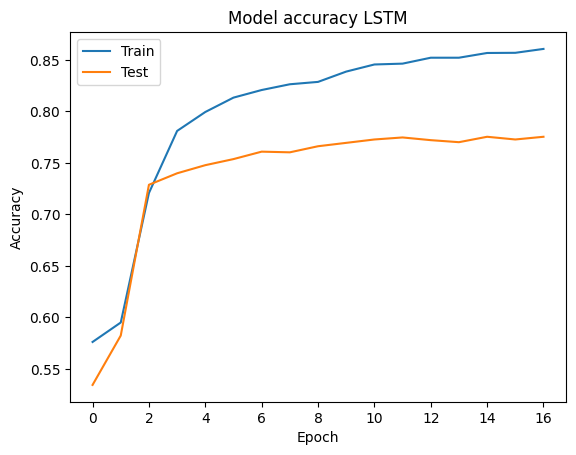

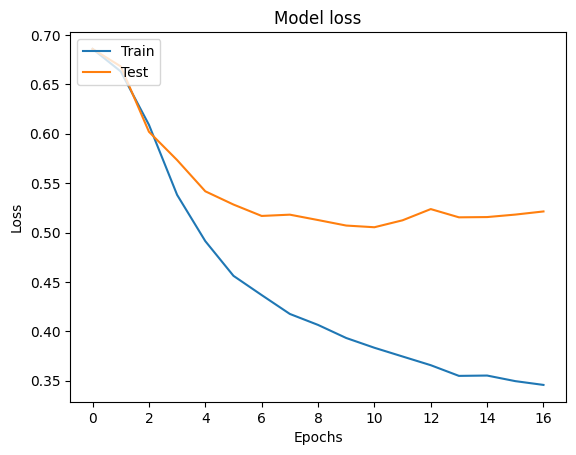

In [11]:
build_validation_graph(history, 'LSTM')

# Bidirectional Long Short Term Memory (Bi-LSTM)

In [12]:
encoder_bi_lstm = build_encoder(X_train, project_data.vocabulary_size)

model_bi_lstm = Sequential()
model_bi_lstm.add(encoder_bi_lstm)
model_bi_lstm.add(Embedding(input_dim=len(encoder_bi_lstm.get_vocabulary()),output_dim=output_dims, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(output_dims,return_sequences = False)))
model_bi_lstm.add(Dropout(drop_lstm))
model_bi_lstm.add(Dense(1, activation='sigmoid'))
model_bi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, None, 143)         286000    
                                                                 
 bidirectional (Bidirection  (None, 286)               328328    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 286)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 287       
                                                                 
Total params: 614615 (2.34 MB)
Trainable params: 61461

In [13]:
optimizer = Adam(learning_rate=0.00003)
model_bi_lstm.compile(loss = 'binary_crossentropy', optimizer = optimizer , metrics = ['accuracy'])

In [14]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00000001)
history = model_bi_lstm.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks =[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
191/191 [==============================] - 43s 171ms/step - loss: 0.6864 - accuracy: 0.5745 - val_loss: 0.6859 - val_accuracy: 0.5345 - lr: 3.0000e-05
Epoch 2/30
191/191 [==============================] - 26s 135ms/step - loss: 0.6710 - accuracy: 0.5824 - val_loss: 0.6763 - val_accuracy: 0.5410 - lr: 3.0000e-05
Epoch 3/30
191/191 [==============================] - 27s 139ms/step - loss: 0.6350 - accuracy: 0.6588 - val_loss: 0.6155 - val_accuracy: 0.7216 - lr: 3.0000e-05
Epoch 4/30
191/191 [==============================] - 28s 145ms/step - loss: 0.5570 - accuracy: 0.7775 - val_loss: 0.5534 - val_accuracy: 0.7590 - lr: 3.0000e-05
Epoch 5/30
191/191 [==============================] - 28s 148ms/step - loss: 0.5025 - accuracy: 0.8011 - val_loss: 0.5250 - val_accuracy: 0.7728 - lr: 3.0000e-05
Epoch 6/30
191/191 [==============================] - 41s 213ms/step - loss: 0.4649 - accuracy: 0.8140 - val_loss: 0.5087 - val_accuracy: 0.7833 - lr: 3.0000e-05
Epoch 7/30
191/191 [========

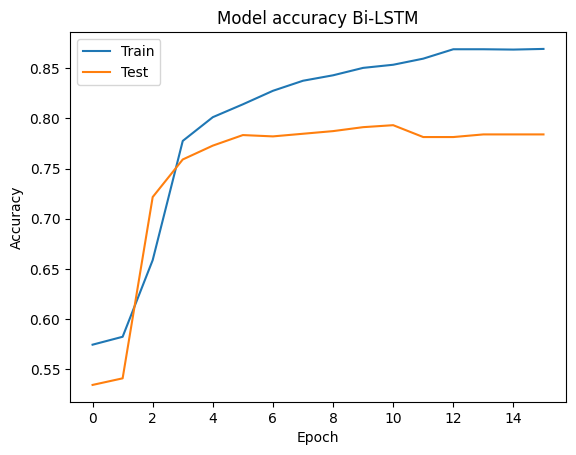

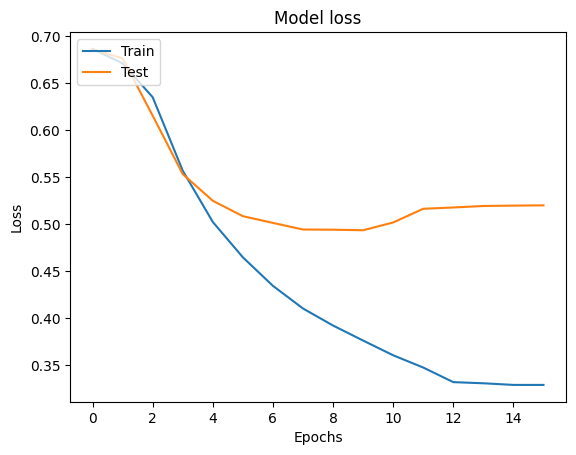

In [15]:
build_validation_graph(history, 'Bi-LSTM')

#  Gated Recurrent Unit (GRU)

In [16]:
encoder_gru = build_encoder(X_train, project_data.vocabulary_size)
model_gru = Sequential()
model_gru.add(encoder_gru)
model_gru.add(Embedding(input_dim=len(encoder_gru.get_vocabulary()),output_dim=output_dims, mask_zero=True))
model_gru.add(SpatialDropout1D(0.2))
model_gru.add(GRU(128, return_sequences = False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation = 'sigmoid'))

In [17]:
optimizer = Adam(learning_rate=0.00003)
model_gru.compile(loss = 'binary_crossentropy', optimizer = optimizer , metrics = ['accuracy'])

In [18]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001)
history = model_gru.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks =[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
191/191 [==============================] - 19s 68ms/step - loss: 0.6889 - accuracy: 0.5678 - val_loss: 0.6891 - val_accuracy: 0.5345 - lr: 3.0000e-05
Epoch 2/30
191/191 [==============================] - 11s 57ms/step - loss: 0.6800 - accuracy: 0.5793 - val_loss: 0.6870 - val_accuracy: 0.5345 - lr: 3.0000e-05
Epoch 3/30
191/191 [==============================] - 12s 60ms/step - loss: 0.6722 - accuracy: 0.5793 - val_loss: 0.6843 - val_accuracy: 0.5345 - lr: 3.0000e-05
Epoch 4/30
191/191 [==============================] - 12s 61ms/step - loss: 0.6583 - accuracy: 0.5954 - val_loss: 0.6675 - val_accuracy: 0.5424 - lr: 3.0000e-05
Epoch 5/30
191/191 [==============================] - 12s 65ms/step - loss: 0.6038 - accuracy: 0.7010 - val_loss: 0.5883 - val_accuracy: 0.7341 - lr: 3.0000e-05
Epoch 6/30
191/191 [==============================] - 12s 65ms/step - loss: 0.5381 - accuracy: 0.7823 - val_loss: 0.5519 - val_accuracy: 0.7511 - lr: 3.0000e-05
Epoch 7/30
191/191 [==============

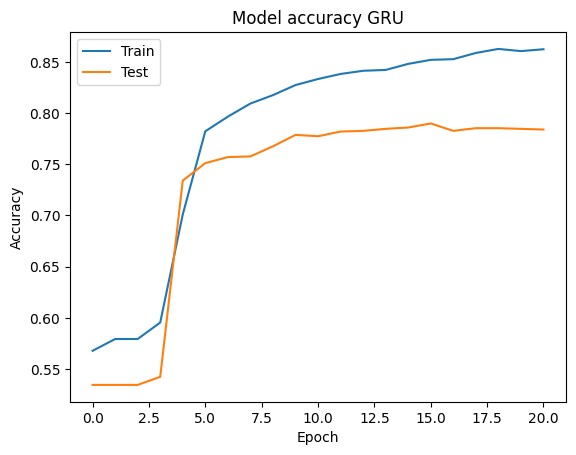

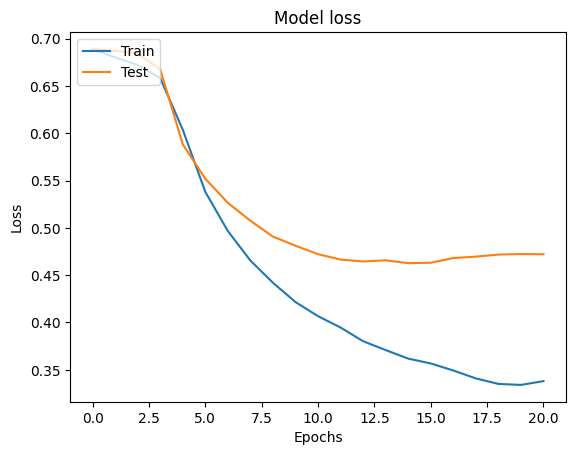

In [19]:
build_validation_graph(history, 'GRU')

In [24]:
preds = (model_lstm.predict(np.array(project_data.X_test.to_list()))> 0.5).astype('int')
submission = pd.DataFrame({'id':project_data.test_ids.to_list(), 'target':preds.flatten()})
submission.to_csv(f'{DATA_PATH}/disaster_tweets/submission.csv', index=False)

102/102 [==============================] - 2s 22ms/step
